# HW2 Part 3: Lasso

Authors:
- Farzan Memarian fm6996
- Timothy Mahler tam2643
- Meghana Venkata Palukuri mvp549

Below are the answers for part a-d.
Below D is a summary of training time, Lasso loss, MSE, MAE and RMSE.

In [98]:
# Import all libs
import numpy as np
import random
import time, sys
import matplotlib.pyplot as plt
from math import sqrt
from numpy import linalg as LA
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Base functions
current_milli_time = lambda: int(round(time.time() * 1000))

In [94]:
# Generate random array
def rand_beta_arr(dim, num_nz):
    B = np.zeros(dim)
    for i in range(num_nz):
        B[i] = np.random.uniform(low=-10, high=10, size=(1,)) # Genrate ranomd weights between -10, 10
    np.random.shuffle(B)
    B = np.reshape(B, (-1, 1))
    return B


# Generate data
N = 10**5 # num data points
p = 500 # num variables
rand_state = 12345
np.random.seed(rand_state) # Set random seet so all numbers stay the same
B_true = rand_beta_arr(500, int(p/25)) # true betas

# Generate random covariance matrix
A = np.random.rand(p, p)
cov_matrix = np.dot(A, A.transpose())

# Gen X, Y
X_orig = np.random.multivariate_normal(mean=np.zeros(p), cov=np.identity(p), size = N)
y_orig = np.matmul(X_orig, B_true)

# Cross validation
lambdas = [1, 0.5, 0.1, 0.01] # Lamdas to test for K-Fold
CV_rounds = 5 # number of cross validation rounds
kf = KFold(n_splits=CV_rounds, random_state=rand_state)
from math import sqrt

# Test / Train
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size = 0.5)


# Print Values
#print (B_true)
# print (X)
# print (Y)
#print (X_train)
#print (y_train)current_milli_time

print ("X_train shape = ", X_train.shape)
print ("X_test shape = ", X_test.shape)
print ("y_train shape = ", y_train.shape)
print ("y_test shape = ", y_test.shape)

X_train shape =  (50000, 500)
X_test shape =  (50000, 500)
y_train shape =  (50000, 1)
y_test shape =  (50000, 1)


## Part A: Subgradient descent

### K-Fold for Best lamda

In [97]:
from numpy.linalg import norm
from pdb import set_trace

#----------------- Variables -----------------
# these parameters are shared between all parts
alpha = 0.01
beta_0 = np.random.multivariate_normal(np.ones(p), 2 * np.identity(p), size=1).reshape((p,1)) # initial beta

MAX_ITERATIONS = 10000
TOLERANCE = 0.01


#----------------- Functions -----------------
# normalized loss function
def loss(X, y, beta, lam):
    N,_ = np.shape(X)
    return   (1/N) * 0.5 * norm((np.matmul(X,beta)-y), ord=2)**2  + lam * norm(beta, ord=1) 

def subgrad(X, y, beta, lam):
    # gradient of the loss function
    N,_ = np.shape(X)
    return   (1/N) * np.matmul(np.transpose(X),(np.matmul(X, beta)-y)) + lam * np.sign(beta) 

# Return Beta given X, Y, alpha
def subgradient_descent(X, y, lam):
    print ("Subgradient descent for lam = ",lam)
    start = current_milli_time()
    
    beta = np.empty_like(-beta_0)
    beta[:] = beta_0
    loss_arr = []
    
    L = loss(X, y, beta, lam)
    old_loss = sys.maxsize
    L_min = [L, beta]
    counter = 0
    
    while counter < MAX_ITERATIONS and L < old_loss - TOLERANCE:
        beta_old = np.empty_like(beta)
        beta_old[:] = beta
        beta = beta - (alpha * subgrad(X, y, beta, lam))
        delta_beta = norm(beta-beta_old) / p
        old_loss = L
        L = loss(X, y, beta, lam)
        if L < L_min[0]:
            L_min[0] = L
            L_min[1] = beta
        else:
            beta = beta_old
        counter += 1
        
        loss_arr.append((counter, L))
#         if counter % 100 == 0:
#             print ("loss = {}".format(L))
    
    print ("Stop with Loss = ", L)
    print ("------------------------")
    return (beta, current_milli_time() - start, loss_arr)


# Find the best lam using K-Fold
def find_best_lambda():
    print ("Finding the best lambda using K-Fold CV")
    losses = []
    counter = 0
    
    for lam in lambdas:
        test_fold = []
        counter += 1
        print ("testing lambda = ", lam)

        # K-fold
        for train_idx, test_idx in kf.split(X_train):
            xtrain, xtest = X_train[train_idx], X_train[test_idx]
            ytrain, ytest = y_train[train_idx], y_train[test_idx]

            # Run algo
            (B, time, loss_arr) = subgradient_descent(xtrain, ytrain, lam)

            l = loss(xtest, ytest, B, lam)
            test_fold.append(l)

        print ("test_fold done")
        print (test_fold)
        print ("------------------------")
        losses.append(np.mean(test_fold))
        
    print("Losses")
    print (losses)
    return lambdas[np.argmin(losses)]
    
# Best lambda
best_lam = find_best_lambda()
print("Best lambda for subgradient descent = ", best_lam)

Finding the best lambda using K-Fold CV
testing lambda =  1
Subgradient descent for lam =  1
Stop with Loss =  112.00717000723294
------------------------
Subgradient descent for lam =  1
Stop with Loss =  112.05198172487397
------------------------
Subgradient descent for lam =  1
Stop with Loss =  115.21482590094084
------------------------
Subgradient descent for lam =  1
Stop with Loss =  114.10563821387497
------------------------
Subgradient descent for lam =  1
Stop with Loss =  118.92652179423126
------------------------
test_fold done
[111.90708596660279, 111.49407652319749, 115.65728454990833, 114.31705276645492, 119.20095573916554]
------------------------
testing lambda =  0.5
Subgradient descent for lam =  0.5
Stop with Loss =  57.29631016987059
------------------------
Subgradient descent for lam =  0.5
Stop with Loss =  57.96061493426688
------------------------
Subgradient descent for lam =  0.5
Stop with Loss =  57.53881153320892
------------------------
Subgradient de

### Fixed alpha

Generating model
Subgradient descent for lam =  0.01
Stop with Loss =  1.6507864712683546
------------------------

------------Results------------
Train time =  8534
Test lasso loss = 1.6771
MSE = 0.89003
RMSE = 0.94341
MAE = 0.75353
Beta_diff = 0.94676


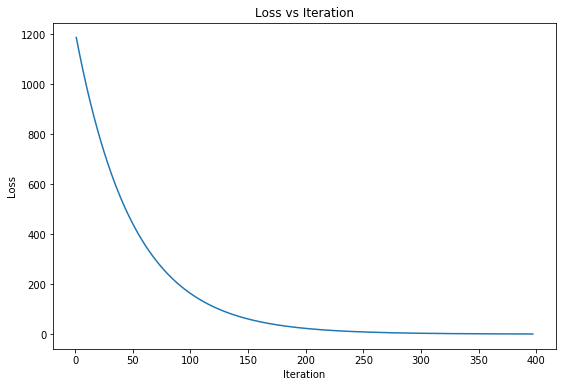

In [100]:
# Create model using best lambda
print ("Generating model")
best_lam = 0.01
(B_model, train_time, loss_arr) = subgradient_descent(X_train, y_train, best_lam)

# Run model on test set
test_loss = loss(X_test, y_test, B_model, best_lam)
y_pred = np.matmul(X_test, B_model)

# Calc metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
beta_diff = LA.norm(B_model - B_true)

print ("\n------------Results------------")
print ("Train time = ", train_time)
print ("Test lasso loss = {0:.5}".format(test_loss))
print ("MSE = {0:.5}".format(mse))
print ("RMSE = {0:.5}".format(rmse))
print ("MAE = {0:.5}".format(mae))
print ("Beta_diff = {0:.5}".format(beta_diff))

# Plot
plt.figure(figsize=(9,6))
plt.plot([i[0] for i in loss_arr], [i[1] for i in loss_arr])
plt.title("Loss vs Iteration")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

### Varying alpha

Generating model for varying alpha
original loss = 1191.5427293115133
iterations for varying alpha done

------------Results------------
Train time =  2206
Test lasso loss = 1.1454
MSE = 0.0026866
RMSE = 0.051833
MAE = 0.041313
Beta_diff = 0.052051


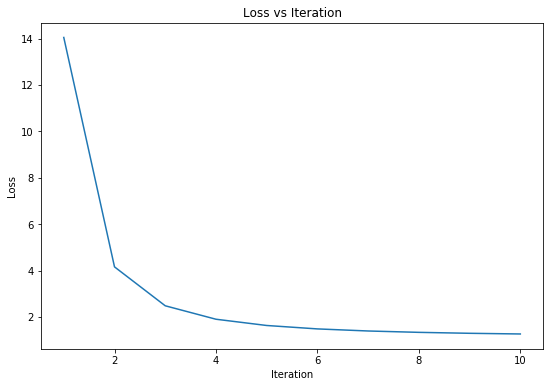

In [112]:
#----------------- Variables -----------------
beta_0 = np.random.multivariate_normal(np.ones(p), 2 * np.identity(p), size=1).reshape((p,1)) # initial beta
best_lam = 0.01 # Found above in Part A
MAX_ITERATIONS = 10000

#----------------- Functions -----------------
# Subgradient descent algo with varying alpha
def subgradient_descent_varying_alpha(X, y, lam):
    start = current_milli_time()
    
    alpha = 1
    alpha_0 = alpha
    beta = np.empty_like(beta_0)
    beta[:] = beta_0
    L = loss(X, y, beta, lam)
    print ("original loss = {}".format(L))
    L_min = [L,beta]
    loss_arr = []
    counter = 0
    while counter < MAX_ITERATIONS:
        counter += 1
        beta_old = np.empty_like(beta)
        beta_old[:] = beta
        beta = beta - (alpha * subgrad(X, y, beta, lam))
        delta_beta = norm(beta-beta_old) / p
        alpha = alpha_0 / (alpha_0 + counter)
        L = loss(X, y, beta, lam)
        if L < L_min[0]:
            L_min[0] = L
            L_min[1] = beta
        else:
            beta = beta_old
            
        loss_arr.append((counter, L))
#         if counter % 100 == 0:
#             print ("loss = {}".format(L))[:1000]
        
    print("iterations for varying alpha done")
    return (beta, current_milli_time() - start, loss_arr)

# Train model using best lambda
print ("Generating model for varying alpha")
(B_model, train_time, loss_arr) = subgradient_descent_varying_alpha(X_train, y_train, best_lam)

# Run model on test set
test_loss = loss(X_test, y_test, B_model, best_lam)
y_pred = np.matmul(X_test, B_model)

# Calc metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
beta_diff = LA.norm(B_model - B_true)

print ("\n------------Results------------")
print ("Train time = ", train_time)
print ("Test lasso loss = {0:.5}".format(test_loss))
print ("MSE = {0:.5}".format(mse))
print ("RMSE = {0:.5}".format(rmse))
print ("MAE = {0:.5}".format(mae))
print ("Beta_diff = {0:.5}".format(beta_diff))

# Plot
plt.figure(figsize=(9,6))
plt.plot([i[0] for i in loss_arr[:10]], [i[1] for i in loss_arr[:10]])
plt.title("Loss vs Iteration")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

## Part B: Proximal gradient descent

Generating model for proximal grad descent
original loss = 1108.0330196021218

------------Results------------
Train time =  8428
Test lasso loss = 1.6718
MSE = 0.87314
RMSE = 0.93442
MAE = 0.74557
Beta_diff = 0.93702


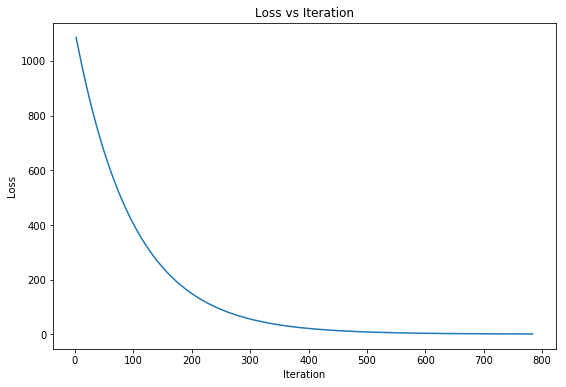

In [103]:
#----------------- Variables -----------------
best_lam = 0.01 # Found above in Part A
MAX_ITERATIONS = 10000
TOLERANCE = 0.01

#----------------- Functions -----------------
def soft_thresh(lam, alpha, beta):
    m, _ = np.shape(beta)
    s_t = np.zeros((m,1))
    for i in range(m):
        if beta[i] > lam * alpha:
            s_t[i,0] = beta[i] - lam * alpha
        elif beta[i] < - lam * alpha:
            s_t[i,0] = beta[i] + lam * alpha
        else:
            s_t[i,0] = 0
    return s_t

def g(beta, X, y):
    # corresponds to the smooth term in the loss
    N,_ = np.shape(X)
    return   (1/N) * 0.5 * norm((np.matmul(X,beta)-y), ord=2)**2 

def grad_g(beta, X, y):
    # corresponds to the gradient of the smooth term in the loss
    N,_ = np.shape(X)
    return   (1/N) * np.matmul(np.transpose(X),(np.matmul(X,beta)-y)) 

# Proximal gradient descent algo
def proximal_gradient_descent(X, y, lam):
    start = current_milli_time()
    
    alpha = 0.01
    beta = np.empty_like(beta_0)
    beta[:] = beta_0
    old_loss = sys.maxsize
    L = loss(X, y, beta, lam)
    print ("original loss = {}".format(L))
    loss_arr = []
    counter = 0
    while counter < MAX_ITERATIONS and L < old_loss - TOLERANCE:
        beta_old = np.empty_like(beta)
        beta_old[:] = beta
        counter += 1
        beta = beta - alpha * grad_g(beta, X, y)
        beta = soft_thresh(lam, alpha, beta)
        old_loss = L
        L = loss(X, y, beta, lam)
        counter += 1
        loss_arr.append((counter, L))
#             print ("loss = {}".format(L))
            
    return (beta, current_milli_time() - start, loss_arr)
    
# Train model using best lambda
print ("Generating model for proximal grad descent")
(B_model, train_time, loss_arr) = proximal_gradient_descent(X_train, y_train, best_lam)

# Run model on test set
test_loss = loss(X_test, y_test, B_model, best_lam)
y_pred = np.matmul(X_test, B_model)

# Calc metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
beta_diff = LA.norm(B_model - B_true)

print ("\n------------Results------------")
print ("Train time = ", train_time)
print ("Test lasso loss = {0:.5}".format(test_loss))
print ("MSE = {0:.5}".format(mse))
print ("RMSE = {0:.5}".format(rmse))
print ("MAE = {0:.5}".format(mae))
print ("Beta_diff = {0:.5}".format(beta_diff))

# Plot
plt.figure(figsize=(9,6))
plt.plot([i[0] for i in loss_arr], [i[1] for i in loss_arr])
plt.title("Loss vs Iteration")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

## Part C: Proximal gradient descent with backtracking line search

Generating model for proximal grad descent with backtracking
original loss = 1108.0330196021218

------------Results------------
Train time =  1279
Test lasso loss = 1.1451
MSE = 0.0021021
RMSE = 0.045849
MAE = 0.036617
Beta_diff = 0.046123


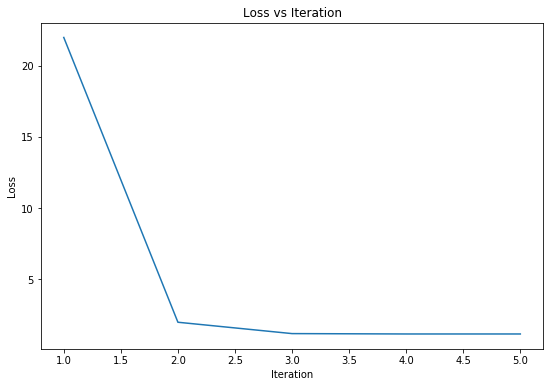

In [107]:
#----------------- Variables -----------------
best_lam = 0.01 # Found above in Part A
MAX_ITERATIONS = 10000
TOLERANCE = 0.01

#----------------- Functions -----------------

# Proximal gradient descent with backtracking line search
def proximal_gradient_descent_with_backtracking(X, y, lam):
    start = current_milli_time()
    
    alpha = 10
    multiplier = 0.9
    # beta_0 = random.multivariate_normal(np.zeros(p), np.identity(p), size=1).reshape((p,1))
    beta = np.empty_like(beta_0)
    beta[:] = beta_0
    L = loss(X, y, beta, lam)
    old_loss = sys.maxsize
    print ("original loss = {}".format(L))
    loss_arr = []
    counter = 0

    while counter < MAX_ITERATIONS and L < old_loss - TOLERANCE:
        beta_old = np.empty_like(beta)
        beta_old[:] = beta

        # while loop is backtracking line search to find optimal alpha
        while True:
            beta_plus = beta - alpha * grad_g(beta, X, y)
            value = g(beta_plus, X, y) > g(beta, X, y) + np.matmul(np.transpose(grad_g(beta, X, y)), 
                    (beta_plus - beta)) + (1/(2*alpha)) * norm(beta_plus-beta)**2
            if value:
                alpha *= multiplier
            else:
                break
#             print ("loss = {}".format(L))

        counter += 1
        beta = beta - alpha * grad_g(beta, X, y)
        beta = soft_thresh(lam, alpha, beta) 

        old_loss = L
        L = loss(X, y, beta, lam)
        
        loss_arr.append((counter, L))
#         if counter % 1 == 0:
#             c4_store.append(counter)
#             print ("loss = {}".format(L))
#             print ("alpha = {}".format(alpha))
#     #         print ("beta diff: {}".format(delta_beta))
#             print ()

    return (beta, current_milli_time() - start, loss_arr)


# Train model using best lambda
print ("Generating model for proximal grad descent with backtracking")
(B_model, train_time, loss_arr) = proximal_gradient_descent_with_backtracking(X_train, y_train, best_lam)

# Run model on test set
test_loss = loss(X_test, y_test, B_model, best_lam)
y_pred = np.matmul(X_test, B_model)

# Calc metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
beta_diff = LA.norm(B_model - B_true)

print ("\n------------Results------------")
print ("Train time = ", train_time)
print ("Test lasso loss = {0:.5}".format(test_loss))
print ("MSE = {0:.5}".format(mse))
print ("RMSE = {0:.5}".format(rmse))
print ("MAE = {0:.5}".format(mae))
print ("Beta_diff = {0:.5}".format(beta_diff))

# Plot
plt.figure(figsize=(9,6))
plt.plot([i[0] for i in loss_arr], [i[1] for i in loss_arr])
plt.title("Loss vs Iteration")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

## Part D: Compare against public software (scikitlearn)

In [91]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

best_lam = 0.01 # Found above in Part A

# Using lasso cross validation K rounds to find best lambda from skleanr package
lcv_model = LassoCV(alphas=None, cv=CV_rounds, max_iter=10000, tol=0.00001)
lcv_model.fit(X_train, y_train)
best_sk_lam = lcv_model.alpha_ # Best alpha selected from CV

print ("Best lambda from LassoCV = ",best_sk_lam)

# Create lasso model using best lam from our experiment
start = current_milli_time()
lasso_model = Lasso(alpha = best_lam, random_state=rand_state, max_iter=10000, tol=0.01)
lasso_model.fit(X_train, y_train)
train_time = current_milli_time() - start

y_pred = lasso_model.predict(X_test)
B_model = lasso_model.coef_
B_model = np.reshape(B_model, (-1, 1))
test_loss = loss(X_test, y_test, B_model, best_lam)

# Calc metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
beta_diff = LA.norm(B_model - B_true)

print ("\n------------Results------------")
print ("Train time = ", train_time)
print ("Test lasso loss = {0:.5}".format(test_loss))
print ("MSE = {0:.5}".format(mse))
print ("RMSE = {0:.5}".format(rmse))
print ("MAE = {0:.5}".format(mae))
print ("Beta_diff = {0:.5}".format(beta_diff))

/home/tim/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best lambda from LassoCV =  0.009796455308071779

------------Results------------
Train time =  354
Test lasso loss = 1.1451
MSE = 0.0019672
RMSE = 0.044353
MAE = 0.035426
Beta_diff = 0.044617


## Results

Overall, after running throuhg 5-Fold CV for our given lambdas, we found that 0.01 was the best lambda. We double checked that this was accurate by running LassoCV from sklearn and found the best lambda was similar at 0.00979.

Below are the results / metrics for each algorithm.

NOTE: the training time for subgradient descent with varying alphas is a lot higher due to the termination condition simply being the max iterations.

From the results you can see that Proximal gradient descent with backtracking performances the best out of the other algorithms in part A-C and performs almost as well as the sklearn Lasso implementation.

In [113]:
from IPython.display import HTML, display
import tabulate
table = [
    ["Algo","Train Time (ms)", "Test Lasso Loss", "MSE", "RMSE", "MAE", "Beta Diff from Truth"],
    ["Subgradient Descent fixed alpha", 8534, 1.6771, 0.89003, 0.94341, 0.75353, 0.94676],
    ["Subgradient Descent varying alpha", 206031, 1.1454, 0.0026866, 0.051833, 0.041313, 0.052051],
    ["Proximal gradient decent", 8428, 1.6718, 0.87314, 0.93442, 0.74557, 0.93702],
    ["Proximal gradient decent w/backtracking", 1279, 1.1451, 0.0021021, 0.045849, 0.36617, 0.046123],
    ["Sklearn Lasso", 354, 1.1451, 0.00196782, 0.044353, 0.035426, 0.044617]
]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Algo,Train Time (ms),Test Lasso Loss,MSE,RMSE,MAE,Beta Diff from Truth
Subgradient Descent fixed alpha,8534,1.6771,0.89003,0.94341,0.75353,0.94676
Subgradient Descent varying alpha,206031,1.1454,0.0026866,0.051833,0.041313,0.052051
Proximal gradient decent,8428,1.6718,0.87314,0.93442,0.74557,0.93702
Proximal gradient decent w/backtracking,1279,1.1451,0.0021021,0.045849,0.36617,0.046123
Sklearn Lasso,354,1.1451,0.00196782,0.044353,0.035426,0.044617
